  # PROJECT 1 - DAML 

## The following project is based around a particle decay from which a parameter related to the matter/anti-matter asymmetry of the Universe will be measured

**The relevant decay X -> D has the following PDF:**

**P( t; V, tau, delta_m ) proportional to (1 + V sin( delta_m · t ) ) x exp( -t/tau )**

**where t is the observable quantity (the decay time of each decay); tau is a lifetime parameter; V is a parameter which measures matter/anti-matter asymmetry and has the value zero if the universe is symmetric (which we know it is not); and delta_m is a mass difference parameter which leads to sinusoidal oscillations superimposed on the exponential decay.**

**The nominal values of the parameters are: tau = 1.5, V = 0.1, delta_m = 20.0.**

**---------------------------------------------------------------------------------------------------------------------------------------------------------------------**

Importing the libraries that I used for the project:

In [1]:
# libraries used
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy import integrate
from iminuit import Minuit

Nominal values given for the parameters, I add a "n" in their variable name so I can come back to them whenever I have to construct a Monte Carlo toy or to compare to get errors. 

In [2]:
# nominal values for paramters
tau_n = 1.5
V_n = 0.1
delta_n = 20.0 #(for the mass difference "Delta m")

## Part 1: Estimating statistical precision

***Use the method of pseudo-experiments (toy Monte Carlo) to determine the expected statistical precision with which one could measure each of the parameters with (i) 10,000 events and (ii) 100,000 events. Assume perfect detector-resolution/perfect time measurements.***

**---------------------------------------------------------------------------------------------------------------------------------------------------------------------**

The first thing I do for this Part 1 is to "study" the PDF function of the decay. I defined the (not normalized!) PDF function below, to be able to plot it and see how it behaves.

In [3]:
def pdf ( t, V, tau, delta_m):
    
    return (1 + V*np.sin(delta_m*t))*np.exp(-t/tau)

By plotting the PDF without normalization for different ranges we can see that the PDF converges to 0 for large values of t. After seeing the plots, it seems that the PDF has already converged to 0 when t > 15 so I choose a range of [0,15] for the analysis.

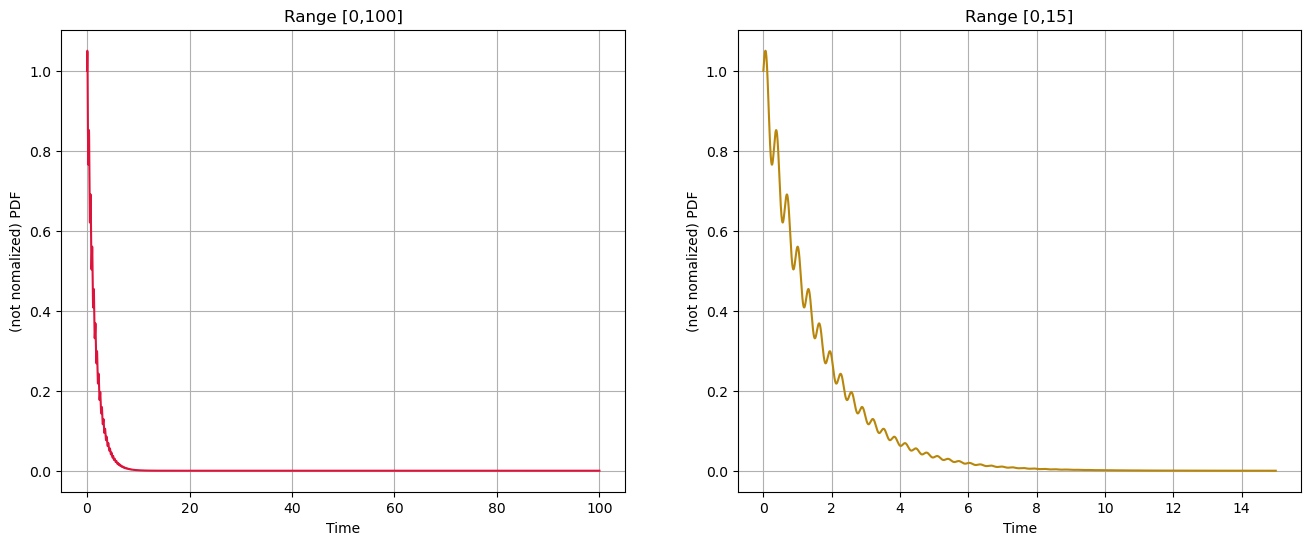

In [4]:
t1 = np.linspace(0,100, 100000)
y1 = pdf(t1, V_n, tau_n, delta_n)

t2 = np.linspace(0,15, 100000)
y2 = pdf(t2, V_n, tau_n, delta_n)

fig, (ax1, ax2) = plt.subplots(1,2, figsize = (16,6))

ax1.plot(t1,y1, color = "crimson")
ax1.set_title("Range [0,100]")
ax1.xaxis.set_label_text("Time")
ax1.yaxis.set_label_text("(not nomalized) PDF")
ax1.grid()

ax2.plot(t2,y2, color = "darkgoldenrod")
ax2.set_title("Range [0,15]")
ax2.xaxis.set_label_text("Time")
ax2.yaxis.set_label_text("(not nomalized) PDF")
ax2.grid()

plt.show()

In [5]:
Range = np.array([0, 15]) # decided range

Now we know that we are going to be interested in the following range for our analysis -> [0,15]. We can therefore normalize our PDF within the range of [0,15] **for the nominal values (when we do the parameters fitting, the integral will vary so it will be inside the function for the definition of the PDF, but for now it is not necessary and we can save some time by keeping it outside and hence only running the integral part once)** by dividing the PDF by the integral of the function within the range as follows:

In [6]:
# Integral of the PDF in the range [0,15]
pdf_function = lambda t: ((1 + V_n*np.sin(delta_n*t))*np.exp(-t/tau_n))
integ = integrate.quad(pdf_function, Range[0], Range[1])[0]

In [7]:
# Normalized PDF function
def pdf_norm ( t, V, tau, delta_m):

    pdf = ((1 + V*np.sin(delta_m*t))*np.exp(-t/tau))
    # normalization
    pdf_norm = pdf/integ
    
    return pdf_norm

We can plot the normalized function to see that it's working as expected (the area has to be equal to one in order to be normalized so we also check that):

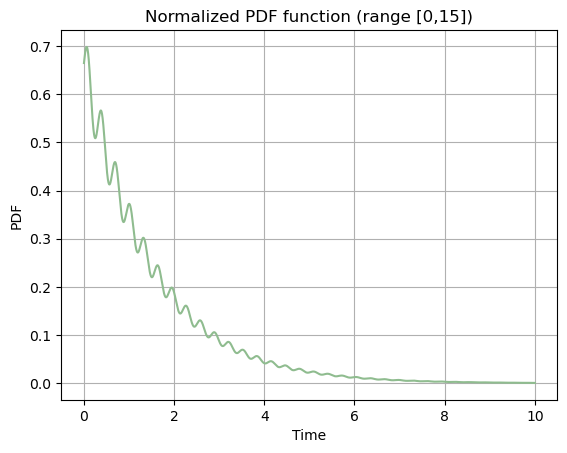

In [8]:
t = np.linspace(0,10, 100000)   # t grid 
y = pdf_norm(t, V_n, tau_n, delta_n)

plt.plot(t, y, "darkseagreen")
plt.title("Normalized PDF function (range [0,15])")
plt.xlabel("Time")
plt.ylabel("PDF")
plt.grid()
plt.show();

In [9]:
# Integral of the PDF in the range [0,15] to check that it's equal to 1
integ_norm = integrate.quad(pdf_norm, Range[0], Range[1],  args=(V_n, tau_n, delta_n))[0]
print(integ_norm)

0.9999999999999998


(The integral is close enough to 1, so the normalization was successful :)

We have successfully defined the normalized PDF so we can now create a toy Monte Carlo with different number of events using the nominal values fo the parameters. Now, our PDF does not follow a "standard" PDF (like normal exponential, normal, etc), so we have to create a random number generator for an arbitrary function.
To do that I am going to employ the **Box method**. This method involves the creation of two random numbers. The code that generates the distribution following our normalized PDF (defined already) is shown in below, what the code does is basically the following:
1. Our normalized PDF is defined in the range [0,15], so every *t* is 0 < *t* < 15.
2. We find a value that is at least greater than the maximum value of the PDF (in the range [0,15]). We call this value *top* as it represents the *top* of the *box* in the method.
3. We generate our first random value *t1* in the range [0,1] using the numpy.random.uniform function. And we convert that random value to be in our range [0,15] by using the following operation; t1 = 0 + (15 - 0) · t1.
4. The we calculate the value of the PDF function (*y1*) at *t1*. (i.e. *y1* = PDF(*t1*)).
5. Next we generate our second random number: *y2* in the range [0,1] again by using the numpy.random.uniform function. And we convert it to be within our (y_axis) range [0, *top] by doing *y2* = *top* · *y2*.
6. Then ,to see if the generated value is in fact within our PDF we perform the test *if y2 < y1*. If it is true then we append the value of *t1* to a list that will contain the generated data. If it is false we discard that *t1* value.

7. This process is repeated in a *while* loop until the list has as many random values of *t1* as desired.

In [10]:
# value larger than the fmax to set as the "top of the box"
top = np.max(y) + 0.01    # Add 0.01 to make sure the top of the box doesn't cut the function

In [11]:
# produces arrays with the generated data with our PDF as the distribution
def toy_generator(n):

    # list to append the generated data
    toy_mc = []

    
    # decided range
    a = Range[0]
    b = Range[1]

    # n is the number of events we want in total
    while int(len(toy_mc)) < n:

        x1 = a + (b - a) * np.random.uniform(low=0.0, high=1.0, size=1)
        y1 = pdf_norm(x1, V_n, tau_n, delta_n)

        y2 = top * np.random.uniform(low=0.0, high=1.0, size=1)

        if y2 < y1 : 

            toy_mc.append(x1)


    toy_mc = np.array(toy_mc)
    
    return toy_mc

Now that we have created a funtion to generate the toy Monte Carlo we can use it to generate toys with different number of events. An example of the histogram computed after generated a toy with 10,000 events and a toy with 100,000 events is shown below in the figures.

In [12]:
toy_small = toy_generator(10000)
toy_big = toy_generator(100000)

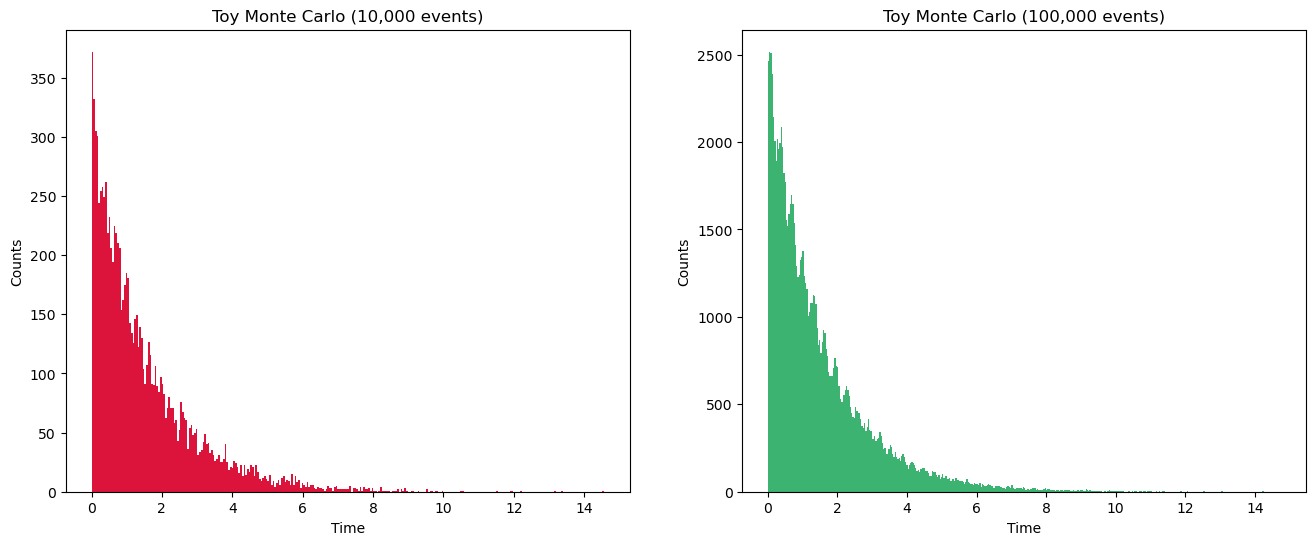

In [13]:
# plot histograms
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (16,6))

ax1.hist(toy_small, color = "crimson",  bins = 300)
ax1.set_title("Toy Monte Carlo (10,000 events)")
ax1.xaxis.set_label_text("Time")
ax1.yaxis.set_label_text("Counts")

ax2.hist(toy_big, color = "mediumseagreen", bins = 400)
ax2.set_title("Toy Monte Carlo (100,000 events)")
ax2.xaxis.set_label_text("Time")
ax2.yaxis.set_label_text("Counts")

plt.show()



Now that we have the toy Monte Carlo we can fit the data to get estimates of the parameters and compare the values when the simulation is of size 10,000 and size 100,000. (*Note how now the normalization is computed inside the PDF as we are changing the parameters when fitting*)

In [14]:
def pdf_fit(t, V, tau, delta_m):
    
    # range [0,15]
    a = Range[0]
    b = Range[1]

    
    pdf_fun = lambda t: ((1 + V*np.sin(delta_m*t))*np.exp(-t/tau))
    integ = integrate.quad(pdf_fun,Range[0], Range[1])[0]
    pdf = ((1 + V*np.sin(delta_m*t))*np.exp(-t/tau))

    pdf_norm = pdf/integ
    
    return pdf_norm
    

when number of events is 10,000:

In [15]:
# Define the negative of the log of the joint likelihood

def NLL_func1(V, tau, delta_m):

    return -1*np.sum(np.log(pdf_fit(toy_small, V, tau, delta_m)))

In [16]:
# Estimate best value of lifetime by minimising NLL using Minuit


m1 = Minuit(NLL_func1, V = V_n, tau = tau_n, delta_m = delta_n)

m1.migrad()  # run optimiser
m1.hesse()   # run covariance estimator

print(m1.values)  # print estimated values
print(m1.errors)  # print error of the estimated values

<ValueView V=0.09529314174653122 tau=1.5044715540825726 delta_m=19.996484696323087>
<ErrorView V=0.020219140286970506 tau=0.021350004964955954 delta_m=0.11020627776949683>


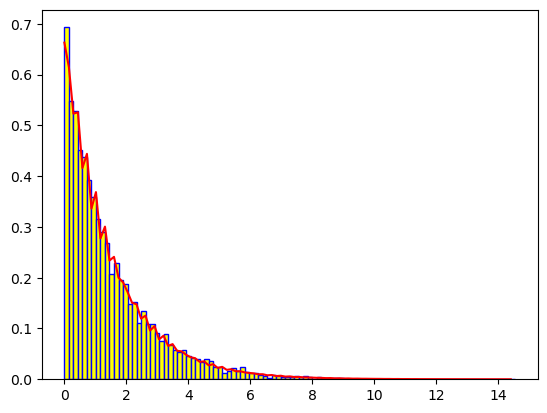

In [17]:
n1, b1, patches1 = plt.hist(toy_small, bins = 100,color = "yellow", ec="blue", density = True )
plt.plot(b1[:-1], pdf_fit(b1[:-1], *m1.values), color = "red")
plt.show();

when number of events is 100,000:

In [18]:
# Define the negative of the log of the joint likelihood

def NLL_func2(V, tau, delta_m):

    return -1*np.sum(np.log(pdf_fit(toy_big, V, tau, delta_m)))

In [19]:
# Estimate best value of lifetime by minimising NLL using Minuit


m2 = Minuit(NLL_func2, V = V_n, tau = tau_n, delta_m = delta_n)

m2.migrad()  # run optimiser
m2.hesse()   # run covariance estimator

print(m2.values)  # print estimated values
print(m2.errors)  # print error of the estimated values

<ValueView V=0.09578699759238095 tau=1.4998632616598568 delta_m=19.994194794822906>
<ErrorView V=0.006339611099312927 tau=0.006730321613348172 delta_m=0.029928267900402324>


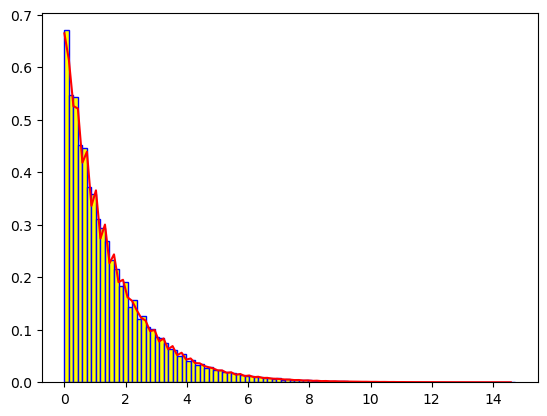

In [20]:
n2, b2, patches2 = plt.hist(toy_big, bins = 100,color = "yellow", ec="blue", density = True )
plt.plot(b2[:-1], pdf_fit(b2[:-1], *m2.values), color = "red")
plt.show();

Parameters comparison between MC 10,000 and 100,000 events:

In [21]:
print("Value comparison:")
print("")
print("10,000 events: V = " + str(np.round(m1.values[0], 3)) + " +/- " +  str(np.round(m1.errors[0], 3)) )
print(" tau = " + str(np.round(m1.values[1], 2)) + " +/- " +  str(np.round(m1.errors[1], 2)) )
print(" Delta_m = " + str(np.round(m1.values[2], 2)) + " +/- " +  str(np.round(m1.errors[2], 2)) )
print("")
print("100,000 events: V = " + str(np.round(m2.values[0], 3)) + " +/- " +  str(np.round(m2.errors[0], 3)) )
print(" tau = " + str(np.round(m2.values[1], 3)) + " +/- " +  str(np.round(m2.errors[1], 3)) )
print(" Delta_m = " + str(np.round(m2.values[2], 2)) + " +/- " +  str(np.round(m2.errors[2], 2)) )

Value comparison:

10,000 events: V = 0.095 +/- 0.02
 tau = 1.5 +/- 0.02
 Delta_m = 20.0 +/- 0.11

100,000 events: V = 0.096 +/- 0.006
 tau = 1.5 +/- 0.007
 Delta_m = 19.99 +/- 0.03


However, if we want a better estimate of the expected statistical precision with which one could measure each of the parameters and their errors;  we run the monte carlo data generator 500 times (as if we were running an experiment 500 to get the values several times to analyze their errors).

In [22]:
def experiment(runs, n):


    # list to store the parameters calculated at each "experiment"
    tau_list = []  
    V_list = []  
    delta_list = []  


    for i in range(runs):



        n = 10000 # number of points
        data_set =  toy_generator(n)  # probability distribution 


        # Define the negative of the log of the joint likelihood

        def NLL_func(V, tau, delta_m):

            return -1*np.sum(np.log(pdf_fit(data_set, V, tau, delta_m)))


        # Estimate best value of lifetime by minimising NLL using Minuit

        m = Minuit(NLL_func, V = V_n, tau = tau_n, delta_m = delta_n)

        m.migrad()  # run optimiser
        m.hesse()   # run covariance estimator

        V_list.append(m.values[0])
        tau_list.append(m.values[1])
        delta_list.append(m.values[2])

    return V_list, tau_list, delta_list


In [23]:
V_list_small, tau_list_small, delta_list_small = experiment(500, 10000)

In [24]:
V_list_big, tau_list_big, delta_list_big = experiment(500, 100000)

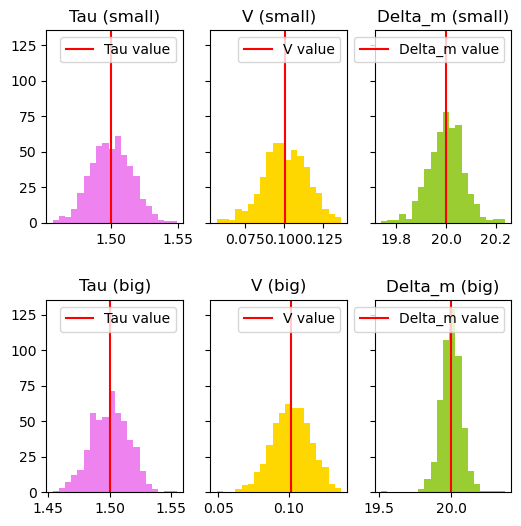

In [100]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(6, 6), sharey=True)

axs[0, 0].hist(tau_list_small, bins = 20, color = "violet")
axs[0, 0].set_title('Tau (small)')
axs[0, 0].axvline(x = np.mean(np.array(tau_list_small)), color = 'red', label = 'Tau value')
axs[0, 0].legend()

axs[0, 1].hist(V_list_small, bins = 20, color = "gold")
axs[0, 1].set_title('V (small)')
axs[0, 1].axvline(x = np.mean(np.array(V_list_small)), color = 'red', label = 'V value')
axs[0,1].legend()

axs[0, 2].hist(delta_list_small, bins = 20, color = "yellowgreen")
axs[0, 2].set_title('Delta_m (small)')
axs[0, 2].axvline(x = np.mean(np.array(delta_list_small)), color = 'red', label = 'Delta_m value')
axs[0, 2].legend()

axs[1, 0].hist(tau_list_big, bins = 20, color = "violet")
axs[1, 0].set_title('Tau (big)')
axs[1, 0].axvline(x = np.mean(np.array(tau_list_big)), color = 'red', label = 'Tau value')
axs[1, 0].legend()

axs[1, 1].hist(V_list_big, bins = 20, color = "gold")
axs[1, 1].set_title('V (big)')
axs[1, 1].axvline(x = np.mean(np.array(V_list_big)), color = 'red', label = 'V value')
axs[1,1].legend()

axs[1, 2].hist(delta_list_big, bins = 20, color = "yellowgreen" )
axs[1, 2].set_title('Delta_m (big)')
axs[1, 2].axvline(x = np.mean(np.array(delta_list_big)), color = 'red', label = 'Delta_m value')
axs[1, 2].legend()


fig.subplots_adjust(hspace=0.4)
plt.show()



The mean of the Gaussian distribution for each parameter obtained after "running" the experiment 500 times give us our "experimental" value for the parameters. The standard deviation of the gaussian gives the numerical precision of the experiment. 

Values of the parameters obtained for toy MC with 10,000 and 100,000 events:

In [101]:
print("Value comparison:")
print("")
print("10,000 events: V = " + str(np.round(np.mean(np.array(V_list_small)), 5)) + " +/- " +  str(np.round(np.std(np.array(V_list_small)), 5)) )
print(" tau = " + str(np.round(np.mean(np.array(tau_list_small)), 6)) + " +/- " +  str(np.round(np.std(np.array(tau_list_small)), 6)) )
print(" Delta_m = " + str(np.round(np.mean(np.array(delta_list_small)), 5)) + " +/- " +  str(np.round(np.std(np.array(delta_list_small)), 5)) )
print("")
print("100,000 events: V = " + str(np.round(np.mean(np.array(V_list_big)), 5)) + " +/- " +  str(np.round(np.std(np.array(V_list_big)), 5)) )
print(" tau = " + str(np.round(np.mean(np.array(tau_list_big)), 6)) + " +/- " +  str(np.round(np.std(np.array(tau_list_big)), 6)) )
print(" Delta_m = " + str(np.round(np.mean(np.array(delta_list_big)), 5)) + " +/- " +  str(np.round(np.std(np.array(delta_list_big)), 5)) )

Value comparison:

10,000 events: V = 0.1008 +/- 0.01406
 tau = 1.500314 +/- 0.015136
 Delta_m = 19.99891 +/- 0.07211

100,000 events: V = 0.10189 +/- 0.01373
 tau = 1.500305 +/- 0.015313
 Delta_m = 20.0003 +/- 0.07403


The difference between using 10,000 events or 100,000 events is not too big. (I used a large numner of decimal numbers to show the differences)

## Part 2: Estimating possible bias due to time resolution

From now on I will be working with the case of 10,000 of events in the toy Monte Carlo (same data set for the rest of the report, called "*toy_small*" In order to make consistent comparisons

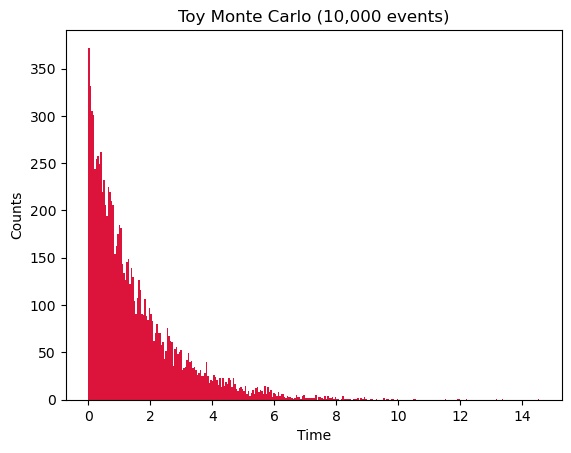

In [102]:
plt.hist(toy_small, color = "crimson",  bins = 300)
plt.title("Toy Monte Carlo (10,000 events)")
plt.xlabel("Time")
plt.ylabel("Counts")

plt.show()

Now we have to take into account the fact that in reality the deacty time is measured with a resolution (random error) with a standard deviation of *sigma = f · tau*, where *f* is some fraction. This means that if the true decay time is *t_true*, then it is actually measured as *t* where *t* is distributed around *t_true* with a Gaussian probability distribution with standard deviation *sigma*.

![t](./t.png)

To determine the bias that will be introduce to the measurement of each of the parameters (when the data is subjected to the resolution effect) I am going to create a Monte Carlo set of data that is "shifted" taking into account the resolution effect (that follows a normal distribution):

In [103]:
f1 = 0.01
f2 = 0.03

sigma1 = tau_n * f1
sigma2 = tau_n * f2


t_shifted1 = np.random.normal(toy_small, sigma1)
t_shifted2 = np.random.normal(toy_small, sigma2)

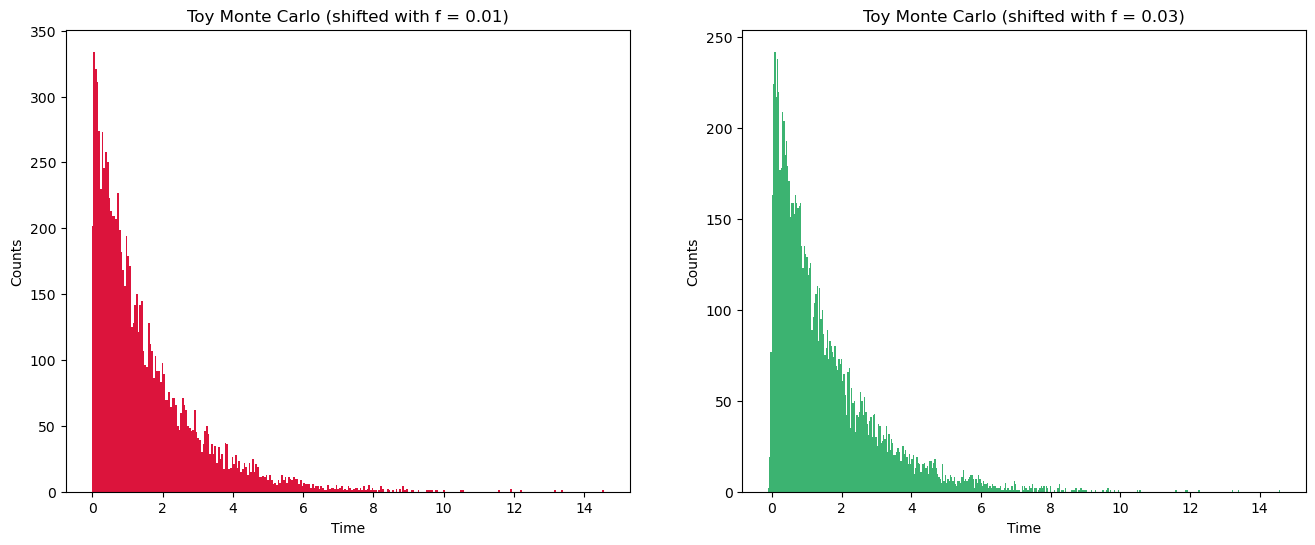

In [104]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (16,6))

ax1.hist(t_shifted1, color = "crimson",  bins = 300)
ax1.set_title("Toy Monte Carlo (shifted with f = 0.01)")
ax1.xaxis.set_label_text("Time")
ax1.yaxis.set_label_text("Counts")

ax2.hist(t_shifted2, color = "mediumseagreen", bins = 400)
ax2.set_title("Toy Monte Carlo (shifted with f = 0.03)")
ax2.xaxis.set_label_text("Time")
ax2.yaxis.set_label_text("Counts")

plt.show()

Now, our data sets are now shifted because of the resolution effect. We fit these data set with the same PDF probability we have been using so far (so we do not take into account in the PDF for fitting the resolution effect.

*for f = 0.01:*

In [105]:
# Define the negative of the log of the joint likelihood

def NLL_func3(V, tau, delta_m):

    return -1*np.sum(np.log(pdf_fit(t_shifted1, V, tau, delta_m)))

In [106]:
# Estimate best value of lifetime by minimising NLL using Minuit


m3 = Minuit(NLL_func3, V = V_n, tau = tau_n, delta_m = delta_n)

m3.migrad()  # run optimiser
m3.hesse()   # run covariance estimator

print(m3.values)  # print estimated values
print(m3.errors)  # print error of the estimated values

<ValueView V=0.0825381297376904 tau=1.5038865052233685 delta_m=19.975594673002462>
<ErrorView V=0.02015406435822909 tau=0.02134175501600535 delta_m=0.13159138200023565>


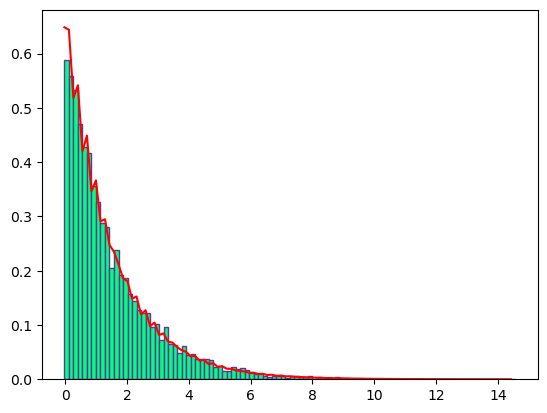

In [107]:
n3, b3, patches3 = plt.hist(t_shifted1, bins = 100,color = "springgreen", ec="rebeccapurple", density = True )
plt.plot(b3[:-1], pdf_fit(b3[:-1], *m3.values), color = "red")
plt.show();

*for f = 0.03:*

In [108]:
# Define the negative of the log of the joint likelihood

def NLL_func4(V, tau, delta_m):

    return -1*np.sum(np.log(pdf_fit(t_shifted2, V, tau, delta_m)))

In [109]:
# Estimate best value of lifetime by minimising NLL using Minuit


m4 = Minuit(NLL_func4, V = V_n, tau = tau_n, delta_m = delta_n)

m4.migrad()  # run optimiser
m4.hesse()   # run covariance estimator

print(m4.values)  # print estimated values
print(m4.errors)  # print error of the estimated values

<ValueView V=0.03215286616367647 tau=1.5026840711314284 delta_m=19.871507302440815>
<ErrorView V=0.020230932132455214 tau=0.021325721680013558 delta_m=0.2855282264452217>


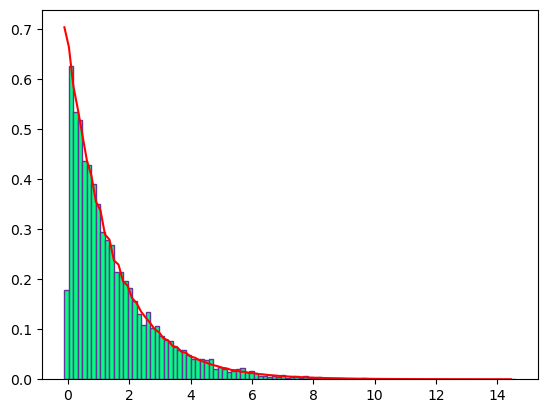

In [110]:
n4, b4, patches4 = plt.hist(t_shifted2, bins = 100,color = "springgreen", ec="rebeccapurple", density = True )
plt.plot(b4[:-1], pdf_fit(b4[:-1], *m4.values), color = "red")
plt.show();

Hence, we can now calculate the bias that was introduced to the measurement of eahc parameter when the data was subjected to the resolution effect. The biased errors due to this resolution effect are the following (by calculating *parameter (from dataset without shift) - parameter (from dataset with shift)*:

In [111]:
print("Value comparison:")
print("")
print("10,000 events NO SHIFT: V = " + str(np.round(m1.values[0], 3)) + " +/- " +  str(np.round(m1.errors[0], 3)) )
print(" tau = " + str(np.round(m1.values[1], 2)) + " +/- " +  str(np.round(m1.errors[1], 2)) )
print(" Delta_m = " + str(np.round(m1.values[2], 2)) + " +/- " +  str(np.round(m1.errors[2], 2)) )
print("")

print("10,000 events SHIFT f = 0.01: V = " + str(np.round(m3.values[0], 3)) + " +/- " +  str(np.round(m3.errors[0], 3)) )
print(" tau = " + str(np.round(m3.values[1], 2)) + " +/- " +  str(np.round(m3.errors[1], 2)) )
print(" Delta_m = " + str(np.round(m3.values[2], 2)) + " +/- " +  str(np.round(m3.errors[2], 2)) )
print("")

print("10,000 events SHIFT f = 0.03: V = " + str(np.round(m4.values[0], 3)) + " +/- " +  str(np.round(m4.errors[0], 3)) )
print(" tau = " + str(np.round(m4.values[1], 2)) + " +/- " +  str(np.round(m4.errors[1], 2)) )
print(" Delta_m = " + str(np.round(m4.values[2], 2)) + " +/- " +  str(np.round(m4.errors[2], 2)) )
print("")

Value comparison:

10,000 events NO SHIFT: V = 0.095 +/- 0.02
 tau = 1.5 +/- 0.02
 Delta_m = 20.0 +/- 0.11

10,000 events SHIFT f = 0.01: V = 0.083 +/- 0.02
 tau = 1.5 +/- 0.02
 Delta_m = 19.98 +/- 0.13

10,000 events SHIFT f = 0.03: V = 0.032 +/- 0.02
 tau = 1.5 +/- 0.02
 Delta_m = 19.87 +/- 0.29



In [112]:
print("Bias values:")
print("")
print("When f = 0.01:")
print("Bias on V = " + str(m1.values[0] - m3.values[0]) )
print("Bias on tau = " + str(m1.values[1] - m3.values[1]))
print("Bias on Delta_m = " + str(m1.values[2] - m3.values[2]))
print("")

print("When f = 0.03:")

print("Bias on V = " + str(m1.values[0] - m4.values[0]) )
print("Bias on tau = " + str(m1.values[1] - m4.values[1]))
print("Bias on Delta_m = " + str(m1.values[2] - m4.values[2]))
print("")

Bias values:

When f = 0.01:
Bias on V = 0.012755012008840827
Bias on tau = 0.0005850488592040737
Bias on Delta_m = 0.020890023320625062

When f = 0.03:
Bias on V = 0.06314027558285476
Bias on tau = 0.0017874829511441703
Bias on Delta_m = 0.12497739388227203



## Part 3: Estimating a systematic error due to time acceptance

For this part we know now that the method of measuring decay-time is thought to exhibit a decay-time acceptance given by:

a(t) = ( 1 + s·t )

where s is only known with a precision of s = 0 +- 0.03

We want to determine a suitable systematic error to assign to the measurement of each of the parameters due to this time acceptance.

***For this Part 3 I'm going to be testing the 3 different methods presented in the lecture to estimate then systematic error due to time acceptance***

The statistical error comes from assuming that everything done for the fitting is the ideal case (assumes that the PDF is the correct PDF for the data, that the background is understood perfectly, that the data is measured perfectly, etc).
While the systematic errors come from our lack of knowledge of many things. In this case the systematic error on the mean is not really big so the calculated total error and the statistical one is the sme for 2 significant figures.

### Part 3.1: Estimating a systematic error due to time acceptance METHOD 1

For this first method we add the acceptance to the PDF (and normalize accordingly). The value of s i changed to s1 = s + s_err. Then fit is then run and the systematic error will be the shift induced on the best fit paramters. This is then repeated for s2 = s - s_err and the systematic error is found with the average of the shift resutls for s1 and s2.

In [113]:
s1 = 0.03 #( s + error s)
s2 = - 0.03 #( s - error s)

In [114]:
def pdf_a1 (t, V, tau, delta_m):
  
    # range [0,10]
    
    a = Range[0]
    b = Range[1]
    
    s = s1
    
    pdf_fun = lambda t: ((1 + V*np.sin(delta_m*t))*np.exp(-t/tau))*(1 + s*t)
    integ = integrate.quad(pdf_fun,Range[0], Range[1])[0]
    #print(integ)
    pdf = ((1 + V*np.sin(delta_m*t))*np.exp(-t/tau))*(1 + s*t)

    pdf_a = pdf/integ
    
    return pdf_a 

In [115]:
# Define the negative of the log of the joint likelihood
def NLL_func_a1(V, tau, delta_m):

    return -1*np.sum(np.log(pdf_a1(toy_small, V, tau, delta_m)))

In [116]:
# Estimate best value of lifetime by minimising NLL using Minuit


ma1 = Minuit(NLL_func_a1, V = V_n, tau = tau_n, delta_m = delta_n)

ma1.migrad()  # run optimiser
ma1.hesse()   # run covariance estimator

print(ma1.values)  # print estimated values
print(ma1.errors)  # print error of the estimated values

<ValueView V=0.09541441958574691 tau=1.4445326926485762 delta_m=19.996510623464538>
<ErrorView V=0.020218802491406094 tau=0.01971201321475372 delta_m=0.11013243545473292>


In [117]:
def pdf_a2 (t, V, tau, delta_m):
  
    # range [0,10]
    
    a = Range[0] 
    b = Range[1]
    
    s = s2
    
    pdf_fun = lambda t: ((1 + V*np.sin(delta_m*t))*np.exp(-t/tau))*(1 + s*t)
    integ = integrate.quad(pdf_fun,Range[0], Range[1])[0]
    #print(integ)
    pdf = ((1 + V*np.sin(delta_m*t))*np.exp(-t/tau))*(1 + s*t)

    pdf_a = pdf/integ
    
    return pdf_a 

In [118]:
# Define the negative of the log of the joint likelihood
def NLL_func_a2(V, tau, delta_m):

    return -1*np.sum(np.log(pdf_a2(toy_small, V, tau, delta_m)))

In [119]:
# Estimate best value of lifetime by minimising NLL using Minuit


ma2 = Minuit(NLL_func_a2, V = V_n, tau = tau_n, delta_m = delta_n)

ma2.migrad()  # run optimiser
ma2.hesse()   # run covariance estimator

print(ma2.values)  # print estimated values
print(ma2.errors)  # print error of the estimated values

<ValueView V=0.09545567210973362 tau=1.5833274174903837 delta_m=19.99644787624658>
<ErrorView V=0.020218707835511707 tau=0.023705947608352027 delta_m=0.11011150674329884>


In [120]:
sys_V = ( (m1.values[0] - ma1.values[0]) + (m1.values[0] - ma2.values[0]) ) /2
sys_tau = ( (m1.values[1] - ma1.values[1]) + (m1.values[1] - ma2.values[1]) ) /2
sys_delta = ( (m1.values[2] - ma1.values[2]) + (m1.values[2] - ma2.values[2]) ) /2

In [121]:
print("Systematic errors:")
print("Presented as Value +- Systematic error")
print("")
print("Due to s1 = s + s_err")
print("V = " + str(np.round(m1.values[0], 4)) + " +/- " +  str(np.round(m1.values[0] - ma1.values[0], 4)) )
print(" tau = " + str(np.round(m1.values[1], 2)) + " +/- " +  str(np.round(m1.values[1] - ma1.values[1], 2)) )
print(" Delta_m = " + str(np.round(m1.values[2], 4)) + " +/- " +  str(np.round(m1.values[2] - ma1.values[2], 4)) )
print("")

print("Due to s2 = s - s_err")
print("V = " + str(np.round(m1.values[0], 4)) + " +/- " +  str(np.round(m1.values[0] - ma2.values[0], 4)) )
print(" tau = " + str(np.round(m1.values[1], 2)) + " +/- " +  str(np.round(m1.values[1] - ma2.values[1], 2)) )
print(" Delta_m = " + str(np.round(m1.values[2], 4)) + " +/- " +  str(np.round(m1.values[2] - ma2.values[2], 4)) )
print("")

print("Total systematic error due to time acceptance (average shift s1 and s2):")
print("V = " + str(np.round(m1.values[0], 4)) + " +/- " +  str(np.round(sys_V, 4)) )
print(" tau = " + str(np.round(m1.values[1], 2)) + " +/- " +  str(np.round(sys_tau, 2)) )
print(" Delta_m = " + str(np.round(m1.values[2], 4)) + " +/- " +  str(np.round(sys_delta, 4)) )
print("")

Systematic errors:
Presented as Value +- Systematic error

Due to s1 = s + s_err
V = 0.0953 +/- -0.0001
 tau = 1.5 +/- 0.06
 Delta_m = 19.9965 +/- -0.0

Due to s2 = s - s_err
V = 0.0953 +/- -0.0002
 tau = 1.5 +/- -0.08
 Delta_m = 19.9965 +/- 0.0

Total systematic error due to time acceptance (average shift s1 and s2):
V = 0.0953 +/- -0.0001
 tau = 1.5 +/- -0.01
 Delta_m = 19.9965 +/- 0.0



In [122]:
tot_V = np.sqrt(sys_V**2 + m1.errors[0]**2)
tot_tau = np.sqrt(sys_tau**2 + m1.errors[1]**2)
tot_delta = np.sqrt(sys_delta**2 + m1.errors[2]**2)

In [123]:
print("Values:")
print("(toy_small data set - 10,000 events)")
print("Value = value + statistical error + systematic error")
print(" V = " + str(np.round(m1.values[0], 3)) + " +/- " +  str(np.round(m1.errors[0], 3))+ " +/- " +   str(np.round(sys_V, 4)))
print(" tau = " + str(np.round(m1.values[1], 2)) + " +/- " +  str(np.round(m1.errors[1], 2))+ " +/- " +  str(np.round(sys_tau, 2)) )
print(" Delta_m = " + str(np.round(m1.values[2], 2)) + " +/- " +  str(np.round(m1.errors[2], 2))+ " +/- " +  str(np.round(sys_delta, 5)) )
print("")
print("")

print("Values:")
print("(toy_small data set - 10,000 events)")
print("Value = value + total error")
print(" V = " + str(np.round(m1.values[0], 3)) + " +/- " +  str(np.round(tot_V, 3)))
print(" tau = " + str(np.round(m1.values[1], 2)) + " +/- " +  str(np.round(tot_tau, 2)) )
print(" Delta_m = " + str(np.round(m1.values[2], 2)) + " +/- " +  str(np.round(tot_delta, 2)))




Values:
(toy_small data set - 10,000 events)
Value = value + statistical error + systematic error
 V = 0.095 +/- 0.02 +/- -0.0001
 tau = 1.5 +/- 0.02 +/- -0.01
 Delta_m = 20.0 +/- 0.11 +/- 1e-05


Values:
(toy_small data set - 10,000 events)
Value = value + total error
 V = 0.095 +/- 0.02
 tau = 1.5 +/- 0.02
 Delta_m = 20.0 +/- 0.11


### Part 3.2: Estimating a systematic error due to time acceptance METHOD 2


For this second method again the time acceptance is added to the PDF and normalized accordingly, then a random value s_r is picked from a Gaussian distribution centred at s and with width s_err. The fit is then re-run for each s_r obtainning shifted values for all thhe parameters with a Gaussian distribution.

In [124]:
s_err = 0.03

tau_shift = []  
V_shift = []  
delta_shift = [] 

for i in range(500):
    
    s_r = np.random.normal(0,s_err)
    
    def pdf_shift (t, V, tau, delta_m):
  
        # range [0,10]

        a = Range[0]
        b = Range[1]

        s = s_r

        pdf_fun = lambda t: ((1 + V*np.sin(delta_m*t))*np.exp(-t/tau))*(1 + s*t)
        integ = integrate.quad(pdf_fun,Range[0], Range[1])[0]
        #print(integ)
        pdf = ((1 + V*np.sin(delta_m*t))*np.exp(-t/tau))*(1 + s*t)

        pdf_a = pdf/integ

        return pdf_a 


    # Define the negative of the log of the joint likelihood
    def NLL_func_shift(V, tau, delta_m):

        return -1*np.sum(np.log(pdf_shift(toy_small, V, tau, delta_m)))
    
    # Estimate best value of lifetime by minimising NLL using Minuit
    m_shift = Minuit(NLL_func_shift, V = V_n, tau = tau_n, delta_m = delta_n)

    m_shift.migrad()  # run optimiser
    m_shift.hesse()   # run covariance estimator

    #print(ma1.values)  # print estimated values
    #print(ma1.errors)  # print error of the estimated values
    
    
    V_shift.append(m_shift.values[0])
    tau_shift.append(m_shift.values[1])
    delta_shift.append(m_shift.values[2])  

/var/folders/dk/1rs_mff912x4vkcx3d1b3nxr0000gn/T/ipykernel_2223/463565775.py:33: RuntimeWarning: invalid value encountered in log
  return -1*np.sum(np.log(pdf_shift(toy_small, V, tau, delta_m)))
/var/folders/dk/1rs_mff912x4vkcx3d1b3nxr0000gn/T/ipykernel_2223/463565775.py:21: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  integ = integrate.quad(pdf_fun,Range[0], Range[1])[0]


In [125]:
print(np.mean(np.array(V_shift)))
print(np.mean(np.array(tau_shift)))
print(np.mean(np.array(delta_shift)))

0.09552806506709297
1.5127695219602824
19.99649822516268


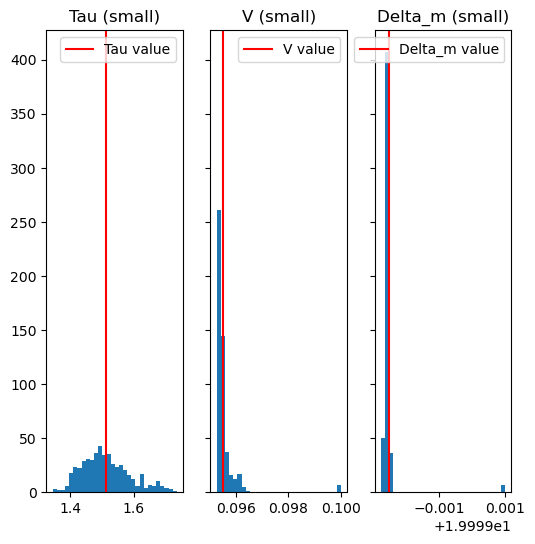

In [126]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(6, 6), sharey=True)

axs[0].hist(tau_shift, bins = 30)
axs[0].set_title('Tau (small)')
axs[0].axvline(x = np.mean(np.array(tau_shift)), color = 'red', label = 'Tau value')
axs[0].legend()

axs[1].hist(V_shift, bins = 30)
axs[1].set_title('V (small)')
axs[1].axvline(x = np.mean(np.array(V_shift)), color = 'red', label = 'V value')
axs[1].legend()

axs[2].hist(delta_shift, bins = 30)
axs[2].set_title('Delta_m (small)')
axs[2].axvline(x = np.mean(np.array(delta_shift)), color = 'red', label = 'Delta_m value')
axs[2].legend()


fig.subplots_adjust(hspace=0.4)
plt.show()



In [127]:
meanV = np.mean(np.array(V_shift))
meantau = np.mean(np.array(tau_shift))
meandelta = np.mean(np.array(delta_shift))

In [128]:
systemaV = np.abs(meanV - m1.values[0])
systematau = np.abs(meantau - m1.values[1])
systemadelta = np.abs(meandelta - m1.values[2])

In [129]:
totV = np.sqrt(m1.errors[0]**2 + systemaV**2)
tottau = np.sqrt(m1.errors[1]**2 + systematau**2)
totdelta = np.sqrt(m1.errors[2]**2 + systemadelta**2)

In [130]:
print("Values:")
print("(toy_small data set - 10,000 events)")
print("Value = value + statistical error + systematic error")
print(" V = " + str(np.round(m1.values[0], 3)) + " +/- " +  str(np.round(m1.errors[0], 3))+ " +/- " +   str(np.round(systemaV, 4)))
print(" tau = " + str(np.round(m1.values[1], 2)) + " +/- " +  str(np.round(m1.errors[1], 2))+ " +/- " +  str(np.round(systematau, 2)) )
print(" Delta_m = " + str(np.round(m1.values[2], 2)) + " +/- " +  str(np.round(m1.errors[2], 2))+ " +/- " +  str(np.round(systemadelta, 6)))
print("")

print("Values:")
print("(toy_small data set - 10,000 events)")
print("Value = value + total error")
print(" V = " + str(np.round(m1.values[0], 3)) + " +/- " +  str(np.round(totV, 3)))
print(" tau = " + str(np.round(m1.values[1], 2)) + " +/- " +  str(np.round(tottau, 2)) )
print(" Delta_m = " + str(np.round(m1.values[2], 3)) + " +/- " +  str(np.round(totdelta, 2)))



Values:
(toy_small data set - 10,000 events)
Value = value + statistical error + systematic error
 V = 0.095 +/- 0.02 +/- 0.0002
 tau = 1.5 +/- 0.02 +/- 0.01
 Delta_m = 20.0 +/- 0.11 +/- 1.4e-05

Values:
(toy_small data set - 10,000 events)
Value = value + total error
 V = 0.095 +/- 0.02
 tau = 1.5 +/- 0.02
 Delta_m = 19.996 +/- 0.11


### Part 3.3: Estimating a systematic error due to time acceptance METHOD 3



For this third method we add a Gaussian constraint. To do this we include "s" as a contrained value in the fit. So know in the PDF s is a free parameter (nuisance parameter). Then we also add a term to the likelihood that makes it likely to be close to s and applies a penalty when it moves away from it. (That said term is added in the NLL by just adding (s_fit - s)^2/(2·s_err^2)

With this method the systematic error is already incorporated in teh given error by the minimizer. So the errors will be quoted as total errors.

In [131]:
s_err = 0.03

In [132]:
def pdf_5 (t, V, tau, delta_m, s):
  
    # range [0,10]
    
    a = Range[0]
    b = Range[1]
    
    pdf_fun = lambda t: ((1 + V*np.sin(delta_m*t))*np.exp(-t/tau))*(1 + s*t)
    integ = integrate.quad(pdf_fun,Range[0], Range[1])[0]
    #print(integ)
    pdf = ((1 + V*np.sin(delta_m*t))*np.exp(-t/tau))*(1 + s*t)

    pdf_3 = pdf/integ
    
    return pdf_3

In [133]:
# Define the negative of the log of the joint likelihood
def NLL_func_5(V, tau, delta_m, s):

    return -1*np.sum(np.log(pdf_5(toy_small, V, tau, delta_m,s))) + (s)**2/(2*s_err)**2

In [134]:
# Estimate best value of lifetime by minimising NLL using Minuit


m5 = Minuit(NLL_func_5, V = V_n, tau = tau_n, delta_m = delta_n, s = 0)

m5.migrad()  # run optimiser
m5.hesse()   # run covariance estimator

print(m5.values)  # print estimated values
print(m5.errors)  # print error of the estimated values

<ValueView V=0.09528795105445079 tau=1.5022796328649606 delta_m=19.996556646828093 s=0.0009605912340611175>
<ErrorView V=0.020219155243413955 tau=0.13554232176892667 delta_m=0.11020472261854569 s=0.05965631040830025>


In [135]:

print("Total error (systematic accounted in the  given statistical) error due to time acceptance (Method 3):")
print("V = " + str(np.round(m5.values[0], 4)) + " +/- " +  str(np.round(m5.errors[0], 4)) )
print(" tau = " + str(np.round(m5.values[1], 2)) + " +/- " +  str(np.round(m5.errors[1], 2)) )
print(" Delta_m = " + str(np.round(m5.values[2], 4)) + " +/- " +  str(np.round(m5.errors[2], 4)) )
print("")

Total error (systematic accounted in the  given statistical) error due to time acceptance (Method 3):
V = 0.0953 +/- 0.0202
 tau = 1.5 +/- 0.14
 Delta_m = 19.9966 +/- 0.1102



**After trying the 3 methods, it seems like the time acceptance impact on the errors is not too big**

# END OF THE NOTEBOOK